In [56]:
# Imports & stuff

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from cycler import cycler





# Constants
time = 3200
pres = []
# all_envs = ["ABC", "Tiger", "RockSample5", "RockSample10", "K-out-of-N2", "K-out-of-N3", 
#             "FrozenLake4", "FrozenLake10", "Tag", "Hallway1", "Hallway2", "MiniHallway", "TigerGrid"] # All envs
Env_to_latex_name = {
    "ABC" : "\\custom",
    "Tiger":"\\tiger",
    "RockSample5": "\\rocksample (5)",
    "RockSample10": "\\rocksample (10)",
    "K-out-of-N2":"\\koutofn (2)",
    "K-out-of-N3":"\\koutofn (3)",
    "FrozenLake4":"\\lake (4)",
    "FrozenLake10":"\\lake (10)",
    "Tag":"\\tagenv",
    "Hallway1":"\\hallway1",
    "Hallway2":"\\hallway2",
    "TigerGrid":"\\tigergrid",
    "MiniHallway":"\\minihallway"
}



all_envs = ["ABC", "Tiger", "RockSample5", "FrozenLake4"] #Testing envs
# all_envs = ["ABC", "Tiger", "RockSample5", "FrozenLake4", "FrozenLake10", "K-out-of-N3"] #Testing envs
pre = "./Data/SarsopTest/Sarsoptest_"
post = f"_t{time}.json"
for env in all_envs:
    pres.append(pre + env + "_" )

# solvers = ["SARSOP", "BIB-SARSOP", "EBIB-SARSOP"]
solvers = ["SARSOP", "BIB-SARSOP", "EBIB-SARSOP"]
# solvers = ["SARSOP", "BIB-SARSOP"]

def get_data(env:str):
    ts, ubs, lbs = [], [], []
    solvernames, envname = [], ""
    for s in solvers:
        with open(pre+env+"_"+s+post) as file:
            data = json.load(file)
            ts.append(data["times"])
            ubs.append(data["ubs"])
            lbs.append(data["lbs"])
            solvernames.append(data["solver"])
            envname = data["env_full"]

    return ts, ubs, lbs, solvernames, envname





In [53]:
# Table of computation times

def get_vars(data:dict):
    if data["timeout"]:
        diff =  abs((data["final_ub"] - data["final_lw"] ) / data["final_lw"])
        # return f'- ({diff:.2f})'
        return f'- ({data["final_lw"]:.2f}, {data["final_ub"]:.2f})'
    else:
        return f'{data["runtime"]:.2f}s'


# labels = ["\\SARSOP", "\\BIBSARSOP", "\\EBIBSARSOP"]
labels = ["None", "\\BIB", "\\EBIB"]
names = []
Sarsop_time, BibSarsop_time, EBibSarsop_time = [], [], []
Sarsop_its, BibSarsop_its, EBibSarsop_its = [], [], []

for pre in pres:
    filename_Sarsop = pre + "SARSOP" + post
    # print(pre)
    with open(filename_Sarsop) as file:
        this_data = json.load(file)
        # names.append(this_data["env_full"])
        names.append(Env_to_latex_name[this_data["env"]])
        Sarsop_time.append(get_vars(this_data))
        Sarsop_its.append(len(this_data["times"]))
        # print("Sarsop: ", len(this_data["times"]))

    filename_BibSarsop = pre + "BIB-SARSOP" + post
    with open(filename_BibSarsop) as file:
        this_data = json.load(file)
        BibSarsop_time.append(get_vars(this_data))
        BibSarsop_its.append(len(this_data["times"]))
        # print("BIBSarsop: ", len(this_data["times"]))

    filename_EBibSarsop = pre + "EBIB-SARSOP" + post
    with open(filename_EBibSarsop) as file:
        this_data = json.load(file)
        EBibSarsop_time.append(get_vars(this_data))
        EBibSarsop_its.append(len(this_data["times"]))
        # print("BIBSarsop: ", len(this_data["times"]))

dataframe = pd.DataFrame([Sarsop_time, BibSarsop_time, EBibSarsop_time], index=labels, columns=names).transpose()

# dataframe = pd.DataFrame([Sarsop_its, BibSarsop_its, EBibSarsop_its], index=labels, columns=names).transpose()


print(dataframe)

print(dataframe.to_latex(column_format="l|ccc"))

                  None   \BIB  \EBIB
\custom          0.49s  2.03s  3.34s
\tiger           0.50s  2.11s  3.29s
\rocksample (5)  0.63s  2.60s  4.55s
\lake (4)        2.14s  2.19s  3.36s
\begin{tabular}{l|ccc}
\toprule
 & None & \BIB & \EBIB \\
\midrule
\custom & 0.49s & 2.03s & 3.34s \\
\tiger & 0.50s & 2.11s & 3.29s \\
\rocksample (5) & 0.63s & 2.60s & 4.55s \\
\lake (4) & 2.14s & 2.19s & 3.36s \\
\bottomrule
\end{tabular}



### Plotting

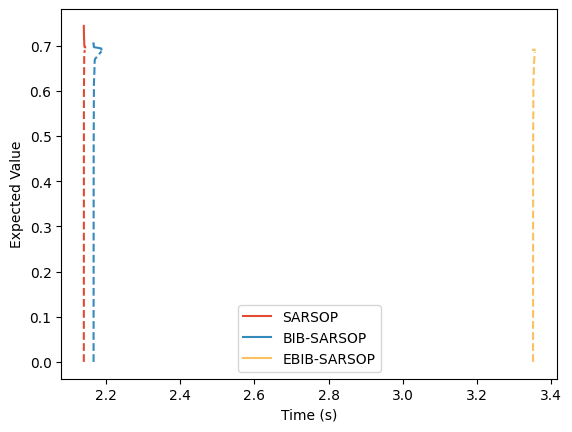

In [58]:
# TigerGrid

ts, ubs, lbs, solvernames, envname = get_data("FrozenLake4")

colours =  ['#E24A33', '#348ABD',  '#FBC15E', '#8EBA42', '#FFB5B8']

# colours = [(226, 74, 51), (52, 138, 189), (152, 142, 213)]

for (i,label) in enumerate(solvernames):
    plt.plot(ts[i],ubs[i], label=label, color=colours[i], linestyle="-")
    plt.plot(ts[i],lbs[i], label=None, color=colours[i], linestyle="--")
plt.xlabel("Time (s)")
plt.ylabel("Expected Value")
# plt.ylim(-3, -1.6)
plt.legend()
plt.show()